# 합성곱 신경망의 시각화 (파이토치)

<table align="left"><tr><td>
<a href="https://colab.research.google.com/github/rickiepark/hg-mldl2/blob/main/08-3.pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="코랩에서 실행하기"/></a>
</td></tr></table>

In [1]:
# 실행마다 동일한 결과를 얻기 위해 파이토치에 랜덤 시드를 지정하고 GPU 연산을 결정적으로 만듭니다.
import torch

torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.backends.cudnn.deterministic = True

In [2]:
# 코랩에서 실행하는 경우에는 다음 명령을 실행하여 best_cnn_model.pt 파일을 다운로드받아 사용하세요.
!wget https://github.com/rickiepark/hg-mldl2/raw/refs/heads/main/best_cnn_model.pt

--2025-01-13 11:16:07--  https://github.com/rickiepark/hg-mldl2/raw/refs/heads/main/best_cnn_model.pt
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/rickiepark/hg-mldl2/refs/heads/main/best_cnn_model.pt [following]
--2025-01-13 11:16:08--  https://raw.githubusercontent.com/rickiepark/hg-mldl2/refs/heads/main/best_cnn_model.pt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1337492 (1.3M) [application/octet-stream]
Saving to: ‘best_cnn_model.pt.1’

best_cnn_model.pt.1 100%[===================>]   1.28M  --.-KB/s    in 0.01s   

2025-01-13 11:16:08 (119 MB/s) - ‘best_cnn_model.pt.1’ saved [13

In [3]:
import torch.nn as nn

model = nn.Sequential()
model.add_module('conv1', nn.Conv2d(1, 32, kernel_size=3, padding='same'))
model.add_module('relu1', nn.ReLU())
model.add_module('pool1', nn.MaxPool2d(2))
model.add_module('conv2', nn.Conv2d(32, 64, kernel_size=3, padding='same'))
model.add_module('relu2', nn.ReLU())
model.add_module('pool2', nn.MaxPool2d(2))
model.add_module('flatten', nn.Flatten())
model.add_module('dense1', nn.Linear(3136, 100))
model.add_module('relu3', nn.ReLU())
model.add_module('dropout', nn.Dropout(0.3))
model.add_module('dense2', nn.Linear(100, 10))

In [4]:
model.load_state_dict(torch.load('best_cnn_model.pt', weights_only=True))

<All keys matched successfully>

In [5]:
layers = [layer for layer in model.children()]
print(layers[0])

Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)


In [6]:
model[0]

Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)

In [7]:
for name, layer in model.named_children():
    print(name, layer)

conv1 Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
relu1 ReLU()
pool1 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
conv2 Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
relu2 ReLU()
pool2 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
flatten Flatten(start_dim=1, end_dim=-1)
dense1 Linear(in_features=3136, out_features=100, bias=True)
relu3 ReLU()
dropout Dropout(p=0.3, inplace=False)
dense2 Linear(in_features=100, out_features=10, bias=True)


In [8]:
model.conv1

Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)

In [9]:
conv_weights = model.conv1.weight.data
print(conv_weights.mean(), conv_weights.std())

tensor(-0.0505) tensor(0.3335)


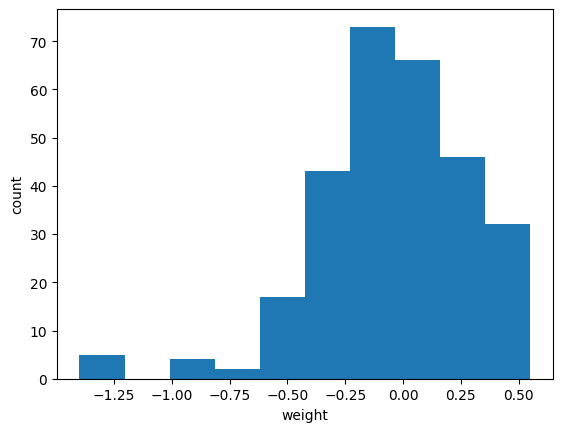

In [10]:
import matplotlib.pyplot as plt

plt.hist(conv_weights.reshape(-1, 1))
plt.xlabel('weight')
plt.ylabel('count')
plt.show()

In [11]:
conv_weights.shape

torch.Size([32, 1, 3, 3])

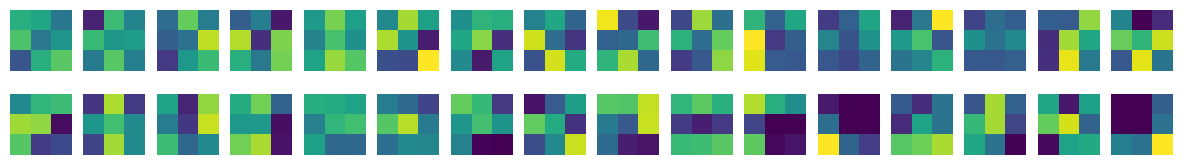

In [12]:
fig, axs = plt.subplots(2, 16, figsize=(15,2))
for i in range(2):
    for j in range(16):
        axs[i, j].imshow(conv_weights[i*16 + j,0,:,:], vmin=-0.5, vmax=0.5)
        axs[i, j].axis('off')
plt.show()

In [13]:
from torchvision.datasets import FashionMNIST

fm_train = FashionMNIST(root='.', train=True, download=True)

In [14]:
train_input = fm_train.data

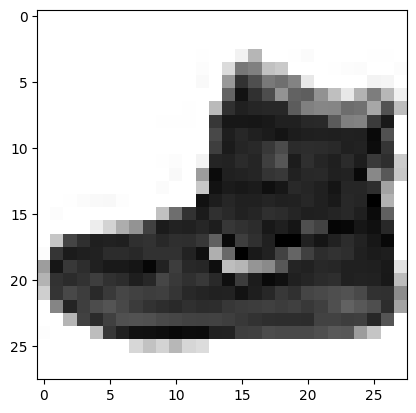

In [15]:
plt.imshow(train_input[0], cmap='gray_r')
plt.show()

In [16]:
inputs = train_input[0:1].reshape(-1, 1, 28, 28) / 255.0

model.eval()
with torch.no_grad():
    feature_maps = model.conv1(inputs)

In [17]:
print(feature_maps.shape)

torch.Size([1, 32, 28, 28])


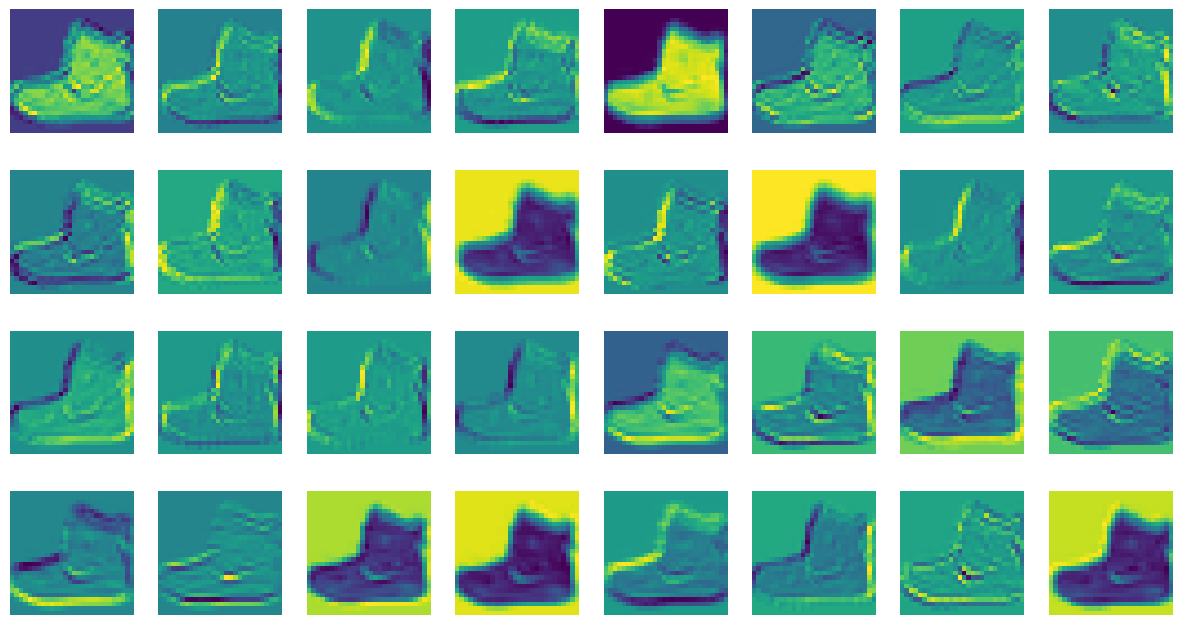

In [18]:
fig, axs = plt.subplots(4, 8, figsize=(15,8))
for i in range(4):
    for j in range(8):
        axs[i, j].imshow(feature_maps.data[0,i*8 + j,:,:])
        axs[i, j].axis('off')
plt.show()

In [19]:
model.eval()
with torch.no_grad():
    feature_maps = model.conv1(inputs)
    feature_maps = model.relu1(feature_maps)
    feature_maps = model.pool1(feature_maps)
    feature_maps = model.conv2(feature_maps)

In [20]:
model.eval()
x = inputs
with torch.no_grad():
    for name, layer in model.named_children():
        x = layer(x)
        if name == 'conv2':
            break

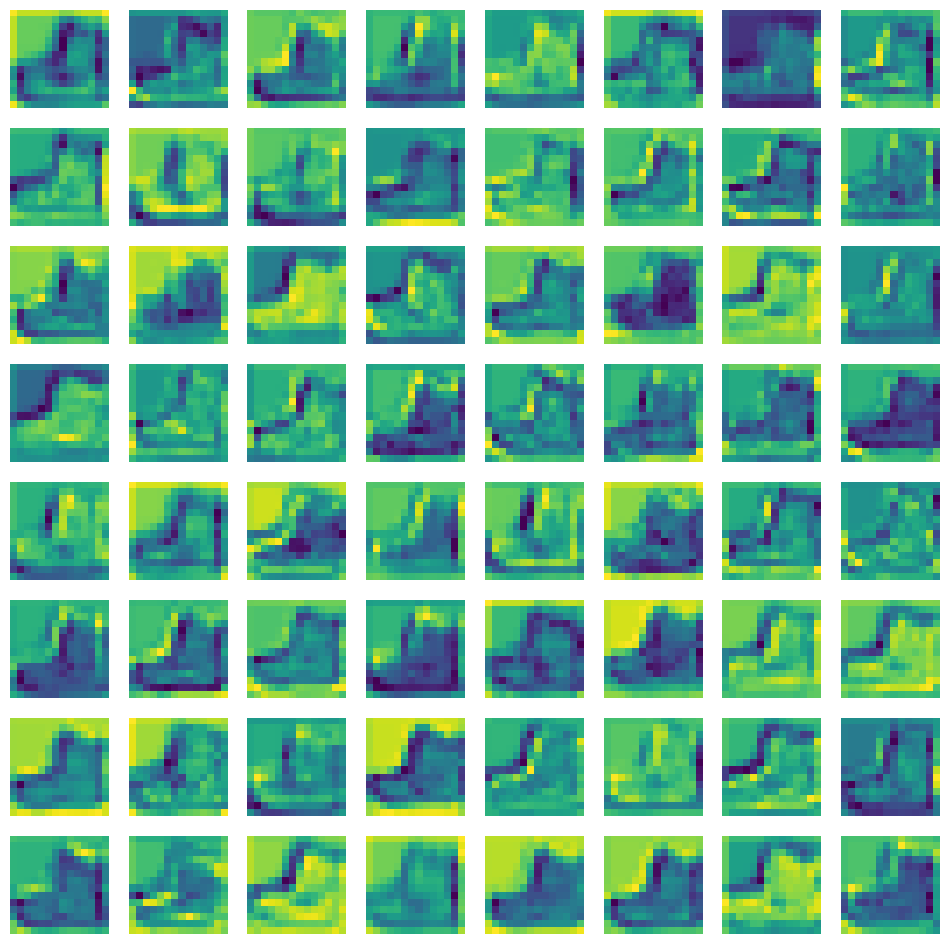

In [21]:
fig, axs = plt.subplots(8, 8, figsize=(12,12))
for i in range(8):
    for j in range(8):
        axs[i, j].imshow(feature_maps.data[0,i*8 + j,:,:])
        axs[i, j].axis('off')
plt.show()